<a href="https://colab.research.google.com/github/MiguelOrtega630/IA_2025/blob/main/Clase_29_de_Octubre_Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✅ Dataset cargado correctamente
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  

Variables seleccionadas: ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Title']
Nulos por columna:
 Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
Title         0
dtype: int64

📊 Árbol base -

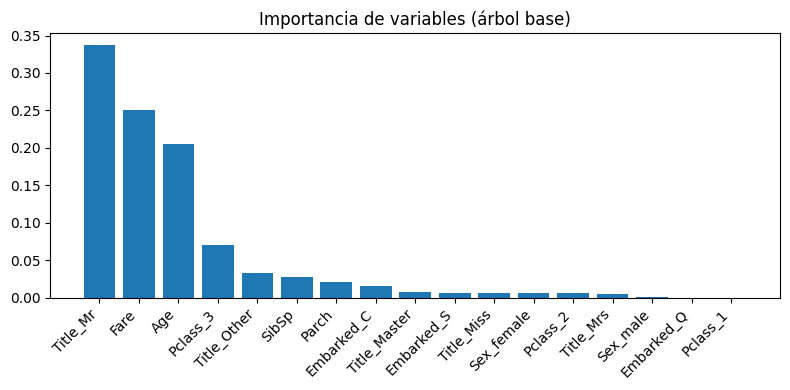


📈 Árbol regresor -> RMSE: 0.4656

🏆 Mejor modelo -> Accuracy: 0.825 | AUC: 0.872 | Gini: 0.744
Mejores parámetros: {'clf__criterion': 'entropy', 'clf__max_depth': 3, 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 2}


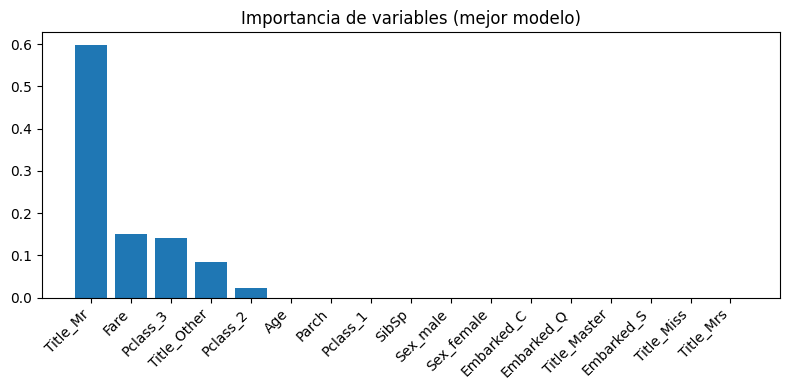

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127795 (\N{DECIDUOUS TREE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


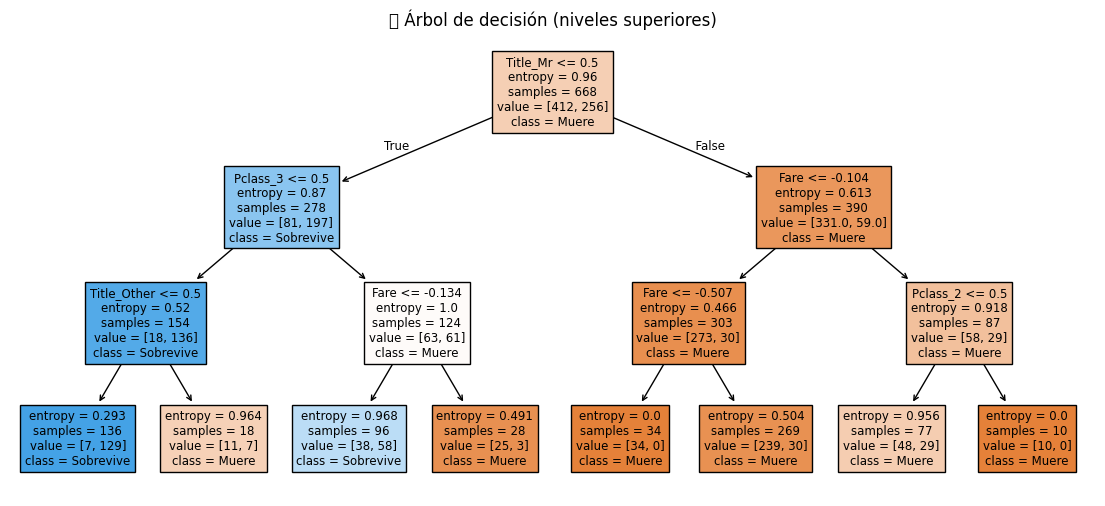


✅ Resumen final:


,Modelo,Accuracy,AUC,Gini,RMSE
0,Árbol Base,0.784753,0.765617,0.531234,NaN
1,Árbol Tuned,0.825112,0.872093,0.744186,NaN
2,Regresor,NaN,NaN,NaN,0.465555


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error


df = pd.read_csv("/content/titanic-train.csv")
print("✅ Dataset cargado correctamente")
print(df.head(3))


if "Survived" not in df.columns and "survived" in df.columns:
    df.rename(columns={"survived": "Survived"}, inplace=True)

if "Name" in df.columns:
    df["Title"] = df["Name"].str.extract(r"([A-Za-z]+)\.")
    df["Title"] = df["Title"].replace({"Mlle": "Miss", "Ms": "Miss", "Mme": "Mrs"})
    df["Title"] = df["Title"].apply(lambda x: x if x in ["Mr", "Mrs", "Miss", "Master"] else "Other")

cols = [c for c in ["Survived","Pclass","Sex","Age","SibSp","Parch","Fare","Embarked","Title"] if c in df.columns]
df = df[cols].copy()

print("\nVariables seleccionadas:", df.columns.tolist())
print("Nulos por columna:\n", df.isnull().sum())


num_features = [c for c in ["Age","Fare","SibSp","Parch"] if c in df.columns]
cat_features = [c for c in ["Pclass","Sex","Embarked","Title"] if c in df.columns]

num_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
cat_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", num_transformer, num_features),
    ("cat", cat_transformer, cat_features)
])

X = df.drop("Survived", axis=1)
y = df["Survived"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)


clf_pipeline = Pipeline([
    ("pre", preprocessor),
    ("clf", DecisionTreeClassifier(random_state=42))
])
clf_pipeline.fit(X_train, y_train)

y_pred = clf_pipeline.predict(X_test)
y_proba = clf_pipeline.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
gini_model = 2 * roc_auc - 1

p = y_train.mean()
gini_root = 1 - (p**2 + (1-p)**2)

print(f"\n📊 Árbol base -> Accuracy: {acc:.3f} | AUC: {roc_auc:.3f} | Gini(model): {gini_model:.3f}")
print(f"Gini del nodo raíz: {gini_root:.3f}")


ohe = clf_pipeline.named_steps["pre"].named_transformers_["cat"].named_steps["onehot"]
cat_names = ohe.get_feature_names_out(cat_features)
feature_names = num_features + list(cat_names)
importances = clf_pipeline.named_steps["clf"].feature_importances_
feat_imp = pd.DataFrame({"Feature": feature_names, "Importance": importances}).sort_values("Importance", ascending=False)

plt.figure(figsize=(8,4))
plt.bar(feat_imp["Feature"], feat_imp["Importance"])
plt.xticks(rotation=45, ha="right")
plt.title("Importancia de variables (árbol base)")
plt.tight_layout()
plt.show()


reg_pipeline = Pipeline([
    ("pre", preprocessor),
    ("reg", DecisionTreeRegressor(random_state=42))
])
reg_pipeline.fit(X_train, y_train)
y_pred_reg = reg_pipeline.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_reg))
print(f"\n📈 Árbol regresor -> RMSE: {rmse:.4f}")


param_grid = {
    "clf__criterion": ["gini", "entropy"],
    "clf__max_depth": [3, 4, 5, 6, None],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 4],
}

grid = GridSearchCV(clf_pipeline, param_grid, cv=5, scoring="roc_auc", n_jobs=-1)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
best_pred = best_model.predict(X_test)
best_proba = best_model.predict_proba(X_test)[:, 1]

best_acc = accuracy_score(y_test, best_pred)
best_auc = roc_auc_score(y_test, best_proba)
best_gini = 2 * best_auc - 1

print(f"\n🏆 Mejor modelo -> Accuracy: {best_acc:.3f} | AUC: {best_auc:.3f} | Gini: {best_gini:.3f}")
print("Mejores parámetros:", grid.best_params_)


imp_best = best_model.named_steps["clf"].feature_importances_
feat_imp_best = pd.DataFrame({"Feature": feature_names, "Importance": imp_best}).sort_values("Importance", ascending=False)

plt.figure(figsize=(8,4))
plt.bar(feat_imp_best["Feature"], feat_imp_best["Importance"])
plt.xticks(rotation=45, ha="right")
plt.title("Importancia de variables (mejor modelo)")
plt.tight_layout()
plt.show()


plt.figure(figsize=(14,6))
plot_tree(best_model.named_steps["clf"], feature_names=feature_names, class_names=["Muere","Sobrevive"], filled=True, max_depth=3)
plt.title("🌳 Árbol de decisión (niveles superiores)")
plt.show()


summary = pd.DataFrame({
    "Modelo": ["Árbol Base", "Árbol Tuned", "Regresor"],
    "Accuracy": [acc, best_acc, None],
    "AUC": [roc_auc, best_auc, None],
    "Gini": [gini_model, best_gini, None],
    "RMSE": [None, None, rmse],
})
print("\n✅ Resumen final:")
display(summary)